In [2]:
%load_ext autoreload
from ddls.plotting.plotting import PlotAesthetics
from ddls.utils import ddls_graph_from_pipedream_txt_file
from ddls.demands.jobs.job import Job

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import glob

from IPython.display import display

In [14]:
%autoreload
# get file paths
# path_to_dirs = '/scratch/datasets/ddls/jobs/pipedream_graphs/image_classification/profiles'
path_to_dirs = '/scratch/datasets/ddls/jobs/pipedream_graphs/translation/profiles'
dir_paths = glob.glob(path_to_dirs + '/*')
file_paths = [dir_path + '/graph.txt' for dir_path in dir_paths]
print(file_paths)
    
# create ddls jobs
jobs = [Job(computation_graph=ddls_graph_from_pipedream_txt_file(file_path, processor_type_profiled='A100', verbose=False),
            num_training_steps=50) 
        for file_path in file_paths]
print(jobs)

# label jobs with model type
for job in jobs:
    # # set model name as graph.txt file's parent folder with the underscores removed
    # job.details['model'] = job.computation_graph.graph['file_path'].split('/')[-2].replace('_', '')
    # set model name as graph.txt file's parent folder
    job.details['model'] = job.computation_graph.graph['file_path'].split('/')[-2]

# visualise
visualise = False
if visualise:
    for job in jobs:
        fig = job.render(scaling_factor=3, title='computation_graph', show_fig=True, verbose=True)
        
for job in jobs:
    print(job)

['/scratch/datasets/ddls/jobs/pipedream_graphs/translation/profiles/gnmt_large/graph.txt', '/scratch/datasets/ddls/jobs/pipedream_graphs/translation/profiles/gnmt/graph.txt']
[<ddls.demands.jobs.job.Job object at 0x7f90852f79d0>, <ddls.demands.jobs.job.Job object at 0x7f90854a5e50>]
Job ID: 140258686499280 | # nodes: 192 | # edges: 245 | # training steps: 50 | Total op mem cost: 4933015040.0 | Total dep size: 3588755456.0
Job ID: 140258688261712 | # nodes: 96 | # edges: 117 | # training steps: 50 | Total op mem cost: 2368446976.0 | Total dep size: 1027801088.0


In [15]:
display(job.details)

display(job.computation_graph.graph)

{'max_compute_node': defaultdict(<function ddls.demands.jobs.job.Job.get_max_node_details.<locals>.<lambda>()>,
             {'A100': 53}),
 'max_compute_cost': defaultdict(<function ddls.demands.jobs.job.Job.get_max_node_details.<locals>.<lambda>()>,
             {'A100': 15.883}),
 'max_memory_node': 48,
 'max_memory_cost': 326949120.0,
 'max_depth_node': 96,
 'max_depth': 30,
 'max_dep_size_dep': (48, 49, 0),
 'max_dep_size': 194437120.0,
 'job_sequential_completion_time': defaultdict(<function ddls.demands.jobs.job.Job.get_job_sequential_completion_time.<locals>.<lambda>()>,
             {'A100': 4470.8}),
 'job_total_op_memory_cost': 2368446976.0,
 'job_total_dep_size': 1027801088.0,
 'communication_overhead_time': 0,
 'computation_overhead_time': 0,
 'mounted_workers': set(),
 'mounted_channels': set(),
 'model': 'gnmt'}

{'file_path': '/scratch/datasets/ddls/jobs/pipedream_graphs/translation/profiles/gnmt/graph.txt',
 'source_nodes': [1, 2, 3, 20, 88, 84, 79, 72, 70, 64, 58, 51],
 'ops_ready': {1, 2, 3, 20, 51, 58, 64, 70, 72, 79, 84, 88},
 'ops_completed': set(),
 'deps_ready': set(),
 'deps_completed': set()}

# All-job Characteristics

In [16]:
all_job_df_dict = defaultdict(list)
for job in jobs:
    all_job_df_dict['Model'].append(job.details['model'])
    
    
    all_job_df_dict['No. Operations'].append(len(list(job.computation_graph.nodes())))
    
    all_job_df_dict['Total Sequential Operation Compute Time'].append(job.details['job_sequential_completion_time']['A100'])
    all_job_df_dict['Max. Operation Compute Time'].append(job.details['max_compute_cost']['A100'])
    
    all_job_df_dict['Total Operation Memory'].append(job.details['job_total_op_memory_cost'])
    all_job_df_dict['Max. Operation Memory'].append(job.details['max_memory_cost'])
    all_job_df_dict['Computation Graph Depth'].append(job.details['max_depth'])
    
    
    all_job_df_dict['No. Dependencies'].append(len(list(job.computation_graph.edges())))
    
    all_job_df_dict['Total Dependency Size'].append(job.details['job_total_dep_size'])
    all_job_df_dict['Max. Dependency Size'].append(job.details['max_dep_size'])
    
all_job_df = pd.DataFrame(all_job_df_dict)
display(all_job_df)

,Model,No. Operations,Total Sequential Operation Compute Time,Max. Operation Compute Time,Total Operation Memory,Max. Operation Memory,Computation Graph Depth,No. Dependencies,Total Dependency Size,Max. Dependency Size
0,gnmt_large,192,26022.65,66.214,4.933015e+09,546208000.0,38,245,3.588755e+09,413696000.0
1,gnmt,96,4470.80,15.883,2.368447e+09,326949120.0,30,117,1.027801e+09,194437120.0


In [17]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

xtick_fontsize = 7
xtick_rotation = 45

step_stats_xaxis = 'step_end_time'
step_stats_xaxis_label = 'Time (s)'

legend = 'auto'

ylog = False
xlog = False

ci = None
errcolor = 'gray'
capsize = 0.05


# display bar chart values
# display_values = True
display_values = False
y_offset = 0
# loc = 'bottom'
loc = 'top'



def show_values_on_bars(axs, sigfigs=2, y_offset=0, loc='top'):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            if loc == 'top':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
    #             _y = p.get_y() + y_offset
                _y = p.get_height() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            elif loc == 'bottom':
                _x = p.get_x() + p.get_width() / 2
    #             _y = p.get_y() + p.get_height()
                _y = p.get_y() + y_offset
                value = sigfig.round(p.get_height(), sigfigs=sigfigs)
                ax.text(_x, _y, value, ha="center") 
            else:
                raise Exception(f'Unrecognised loc {loc}')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

def barplot(df, metric, x='Model', display_values=True):
    print(f'Plotting metric {metric}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.barplot(data=df,
                    x=x,
                    y=metric,
                    # order=order,
                    # palette=palette,
                    estimator=estimator,
                    ci=ci,
                    errcolor=errcolor,
                    capsize=capsize)
    g.set_xlabel(x)
    g.set_ylabel(metric)
    ax.tick_params(axis='both', which='major', pad=2)
    plt.xticks(fontsize=xtick_fontsize,
               rotation=xtick_rotation,
               horizontalalignment='right',
               fontweight='light',
              )
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if ylog:
        g.set(yscale='log')
    if xlog:
        g.set(xscale='log')
    if display_values:
        show_values_on_bars(ax, sigfigs=3, y_offset=y_offset, loc=loc)
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric No. Dependencies


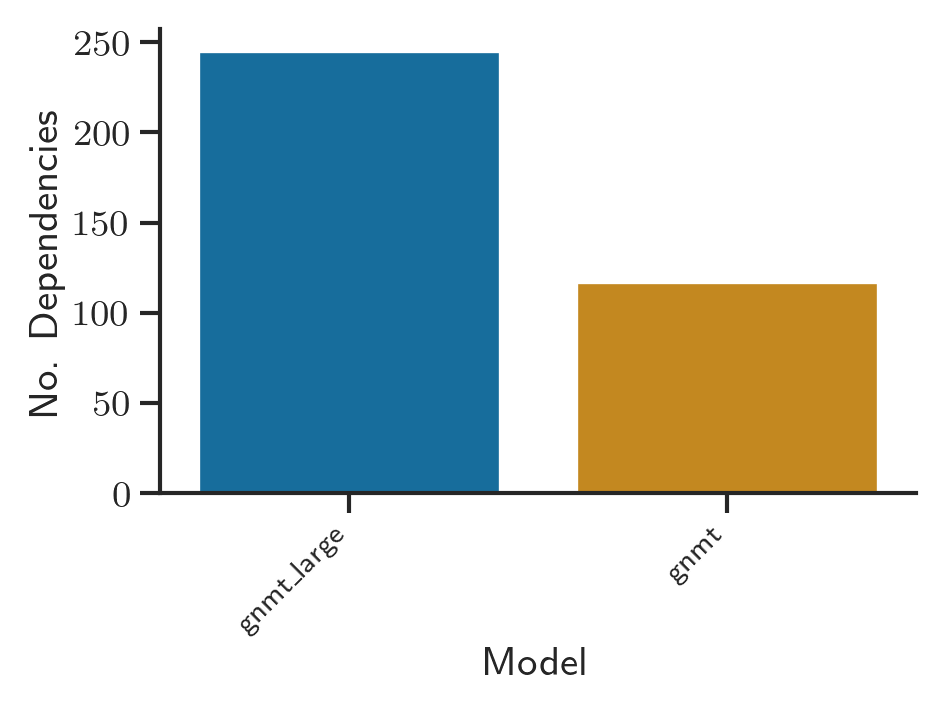

Plotting metric Total Operation Memory


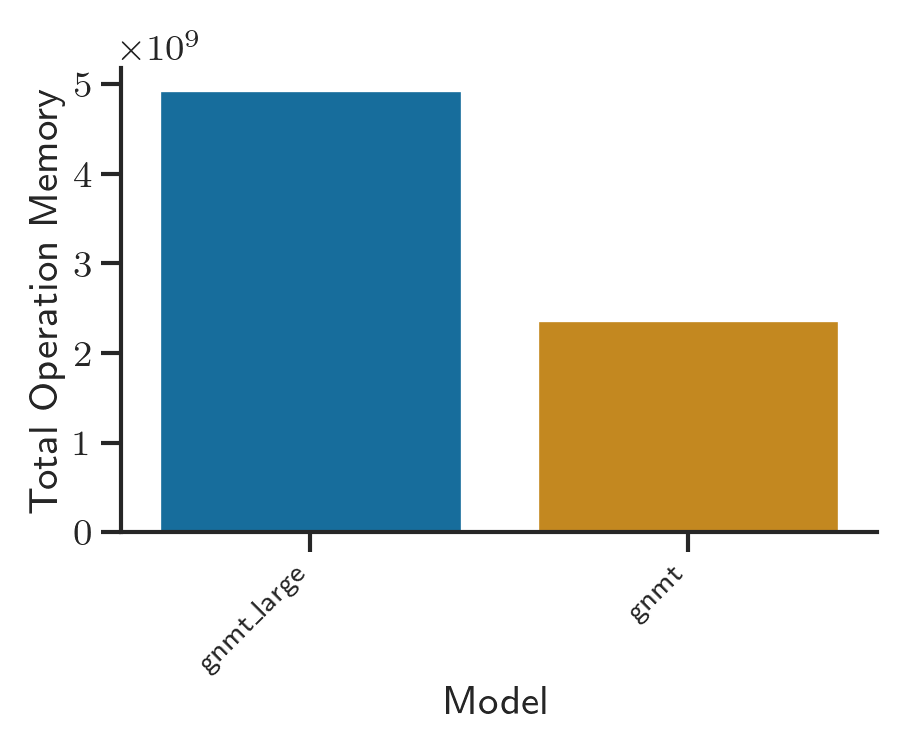

Plotting metric Max. Dependency Size


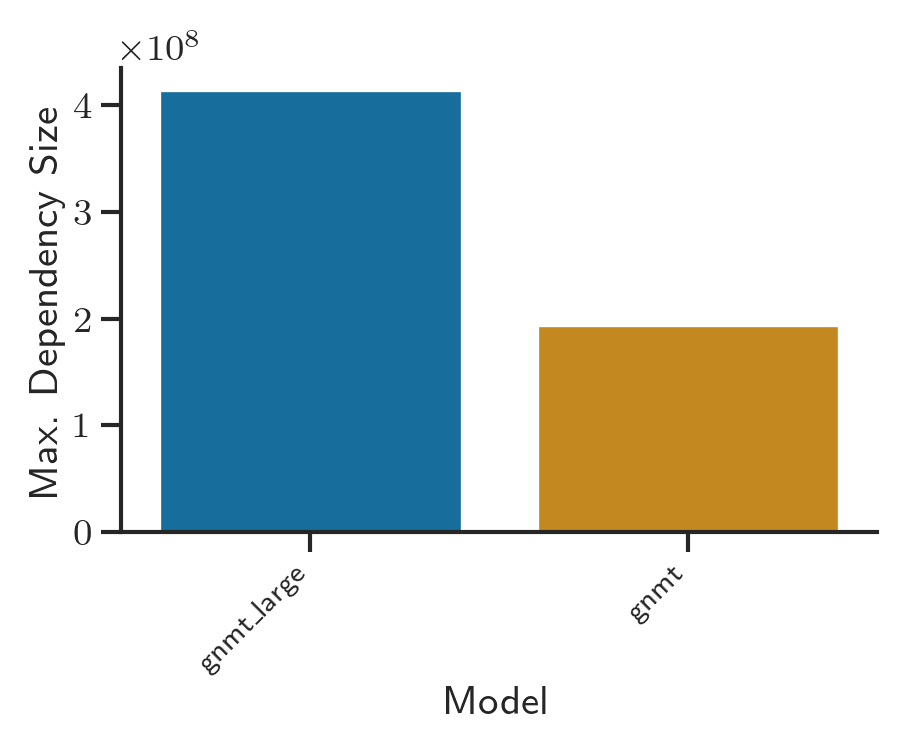

Plotting metric No. Operations


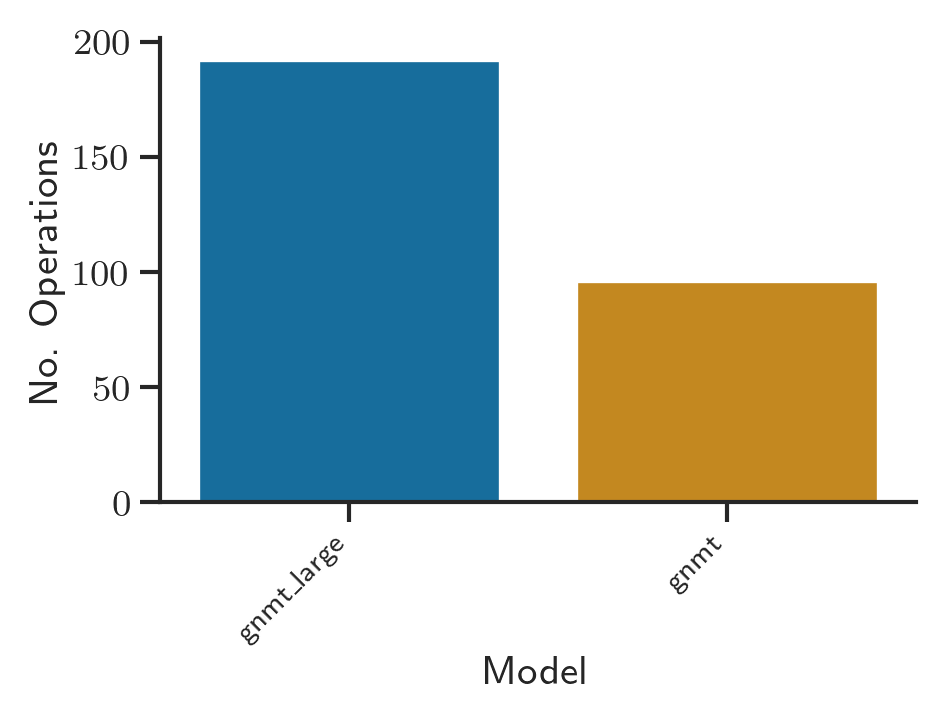

Plotting metric Total Dependency Size


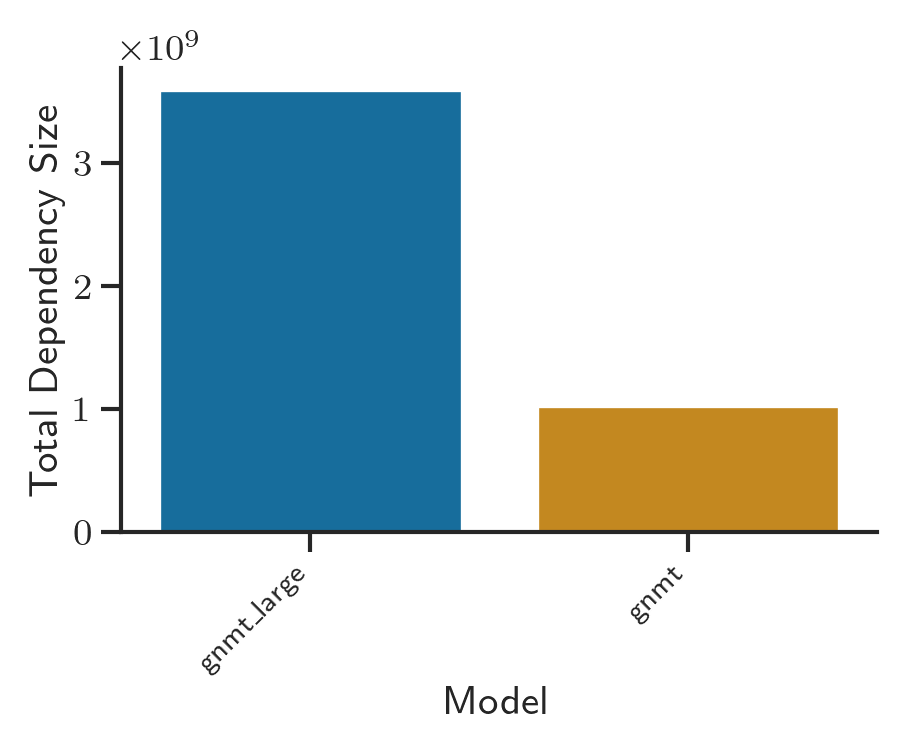

Plotting metric Max. Operation Memory


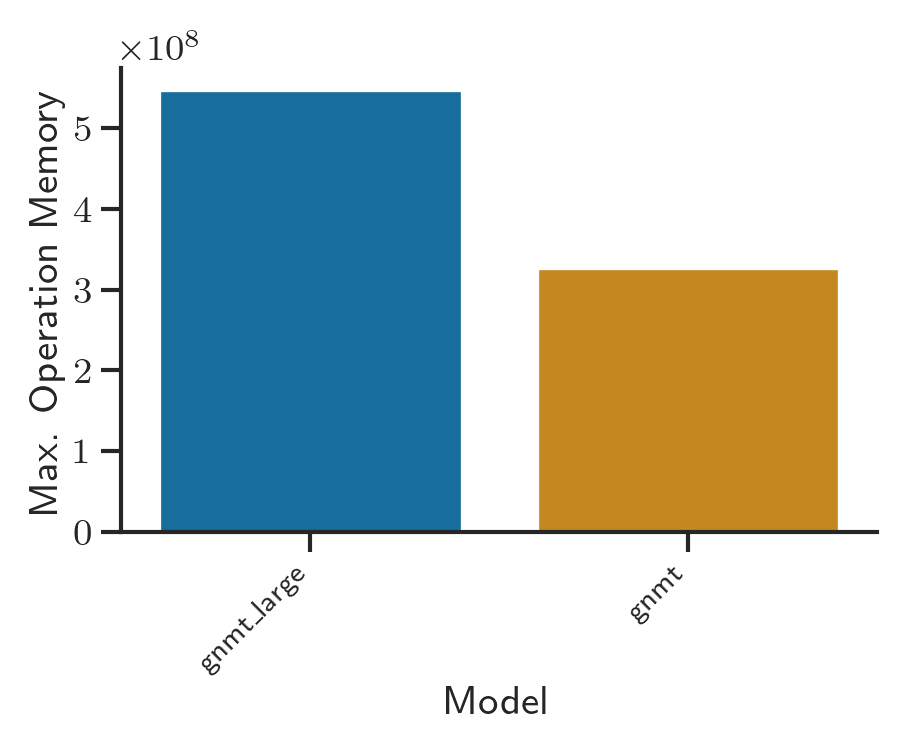

Plotting metric Computation Graph Depth


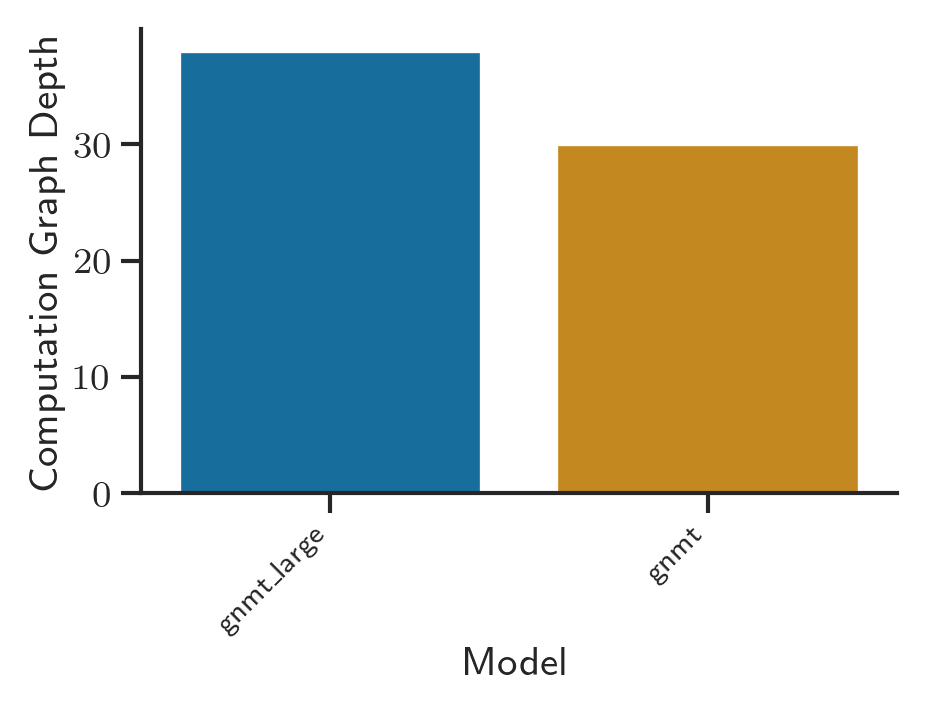

Plotting metric Max. Operation Compute Time


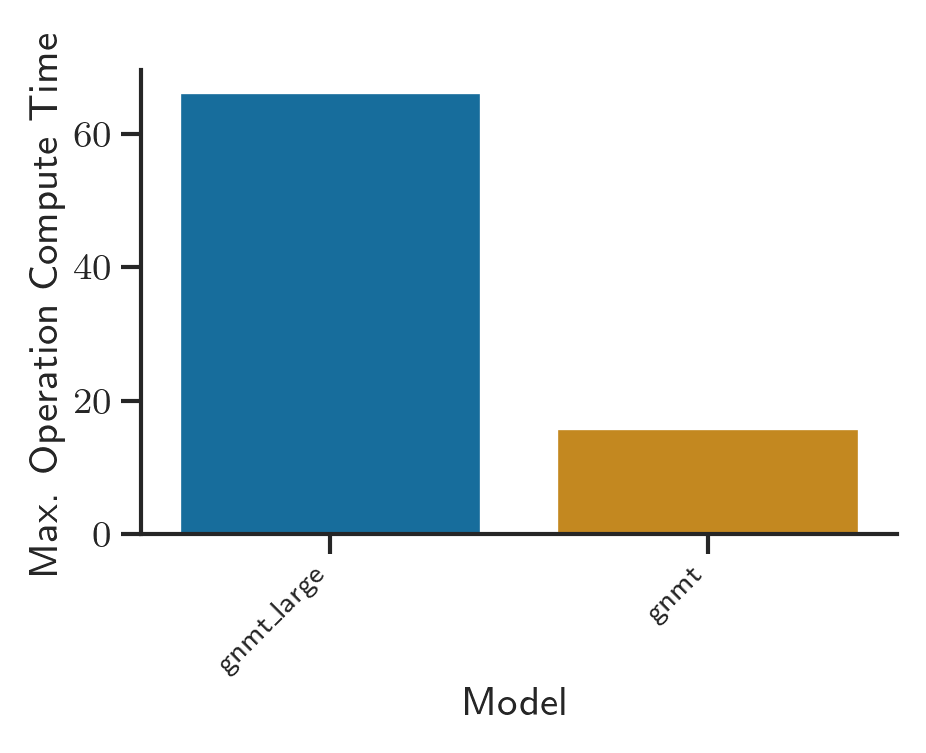

Plotting metric Total Sequential Operation Compute Time


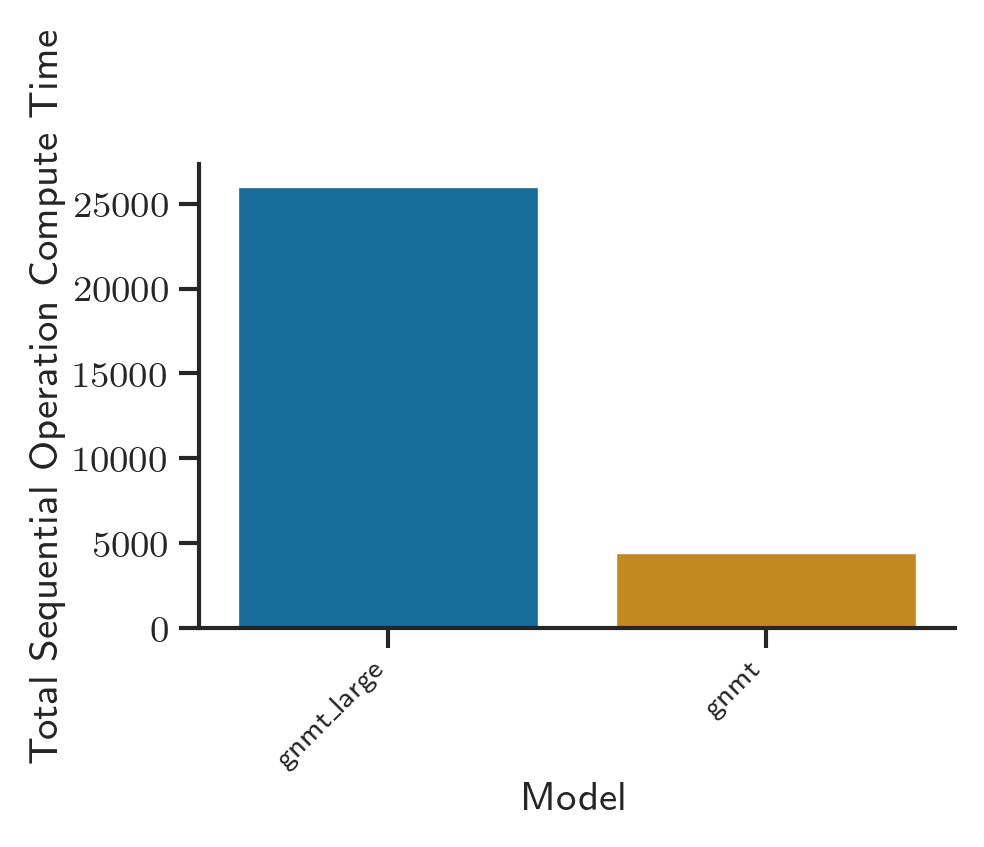

In [18]:
metrics = {metric for metric in all_job_df if metric != 'Model'}

for metric in metrics:
    barplot(df=all_job_df, metric=metric, x='Model', display_values=display_values)

# Per-job Characteristics

In [19]:
metrics = {'op_compute_cost', 'op_memory_cost', 'dep_size'}

node_stats_dict, edge_stats_dict = defaultdict(list), defaultdict(list)

for job in jobs:    
    for node in job.computation_graph.nodes:
        node_stats_dict['Operation Compute Time'].append(job.computation_graph.nodes[node]['compute_cost']['A100'])
        node_stats_dict['Operation Memory'].append(job.computation_graph.nodes[node]['memory_cost'])
        node_stats_dict['Model'].append(job.details['model'])
    
    for edge in job.computation_graph.edges:
        u, v, k = edge
        edge_stats_dict['Dependency Memory'].append(job.computation_graph[u][v][k]['size'])
        edge_stats_dict['Model'].append(job.details['model'])
            
node_stats_df = pd.DataFrame(node_stats_dict)
display(node_stats_df)

edge_stats_df = pd.DataFrame(edge_stats_dict)
display(edge_stats_df)

,Operation Compute Time,Operation Memory,Model
0,0.000,0.0,gnmt_large
1,0.140,145489920.0,gnmt_large
2,14.126,93388800.0,gnmt_large
3,0.000,0.0,gnmt_large
4,0.186,26214400.0,gnmt_large
...,...,...,...
283,15.883,56786944.0,gnmt
284,0.000,6160384.0,gnmt
285,0.000,131072.0,gnmt
286,0.000,6160384.0,gnmt


,Dependency Memory,Model
0,0.0,gnmt_large
1,13107200.0,gnmt_large
2,26214400.0,gnmt_large
3,0.0,gnmt_large
4,0.0,gnmt_large
...,...,...
357,6160384.0,gnmt
358,131072.0,gnmt
359,6160384.0,gnmt
360,6160384.0,gnmt


In [20]:
ylabel = None

xaxis_label_style = 'sci' # paper training curve
# xaxis_label_style = 'plain'

xlog = False
# xlog = True

plot_type = 'cdf'
# plot_type = 'hist'

if plot_type == 'cdf':
    element = 'step' # bars step
    fill = False # True alse
    cumulative = True
    stat = 'probability' # count probability density
    common_norm = False # True False
    multiple = 'layer'
else:
    element = 'bars' # bars step
    fill = True # True alse
    cumulative = False
    stat = 'count' # count probability density
    common_norm = False # True False
    multiple = 'layer'

title = None

# legend = True
legend = False 
# legend = 'auto'
# legend = 'top'
legend_font_size = 7.5 # same as default latex font#
n_rows = 3

xlim = None

ylim = None

scaling_factor = 1
width_scaling_factor = 1
height_scaling_factor = 1

aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics()



def histplot(df, metric, hue='Model'):
    print(f'Plotting metric {metric}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.histplot(data=df,
                 x=metric,
                 hue=hue,
#                  hue_order=list(agent_to_path.keys()),
                 element=element,
                 fill=fill,
                 cumulative=cumulative,
                 stat=stat,
                 common_norm=common_norm,
                 multiple=multiple,
                 log_scale=xlog,
                 legend=legend,
                )
    
#     plt.legend(
# #               loc='upper center',
# #               loc='upper left',
#               # loc='best',
#               bbox_to_anchor=(0.5, 1.2), 
# #               bbox_to_anchor=(0.5, 1.2),
#               labelspacing=0.1,
#               columnspacing=0.2,
#               # ncol=int(len(list(all_job_df_dict.keys()))/n_rows), 
#               prop={'size': legend_font_size},
#     )
    
    g.set_xlabel(metric)
    if ylabel is not None:
        g.set_ylabel(ylabel)
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    # ax.xaxis.label.set_size(2)
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    if ylog:
        g.set(yscale='log')
    if xlog:
        g.set(xscale='log')
        # g.set(xscale='symlog')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric Operation Compute Time


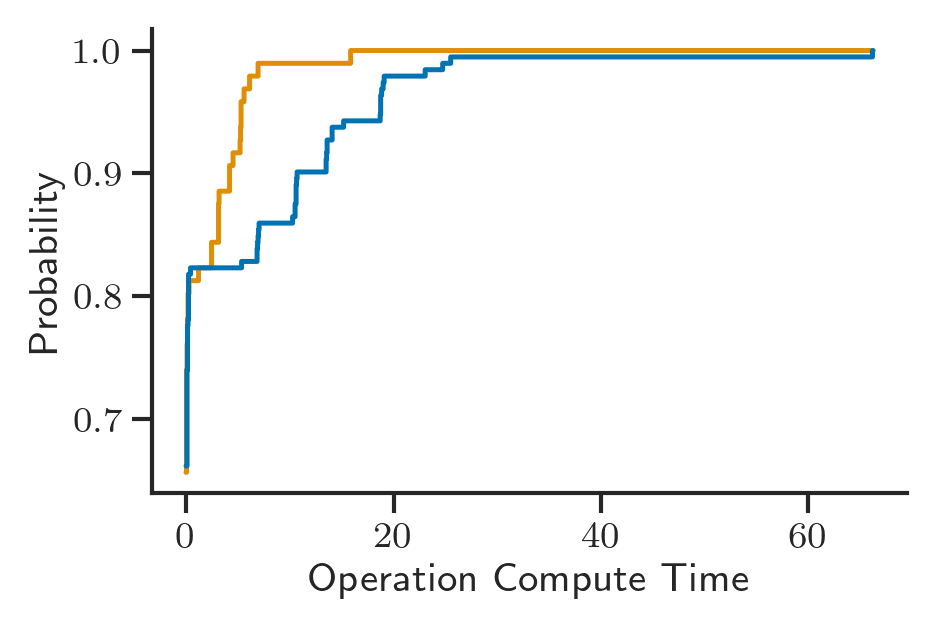

Plotting metric Operation Memory


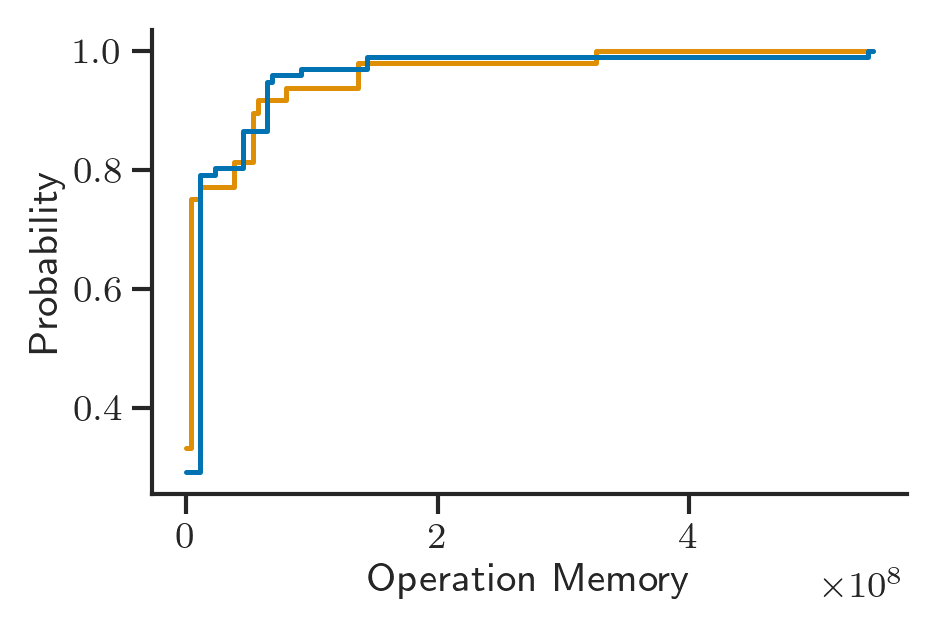

Plotting metric Dependency Memory


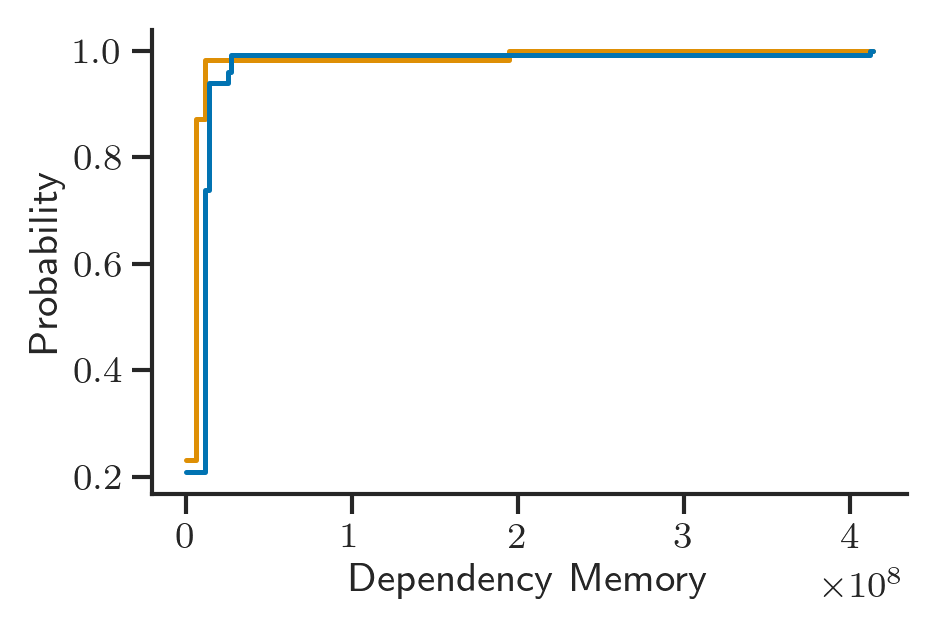

In [21]:
for metric in node_stats_df:
    if metric != 'Model':
        histplot(df=node_stats_df, metric=metric)
        
for metric in edge_stats_df:
    if metric != 'Model':
        histplot(df=edge_stats_df, metric=metric)

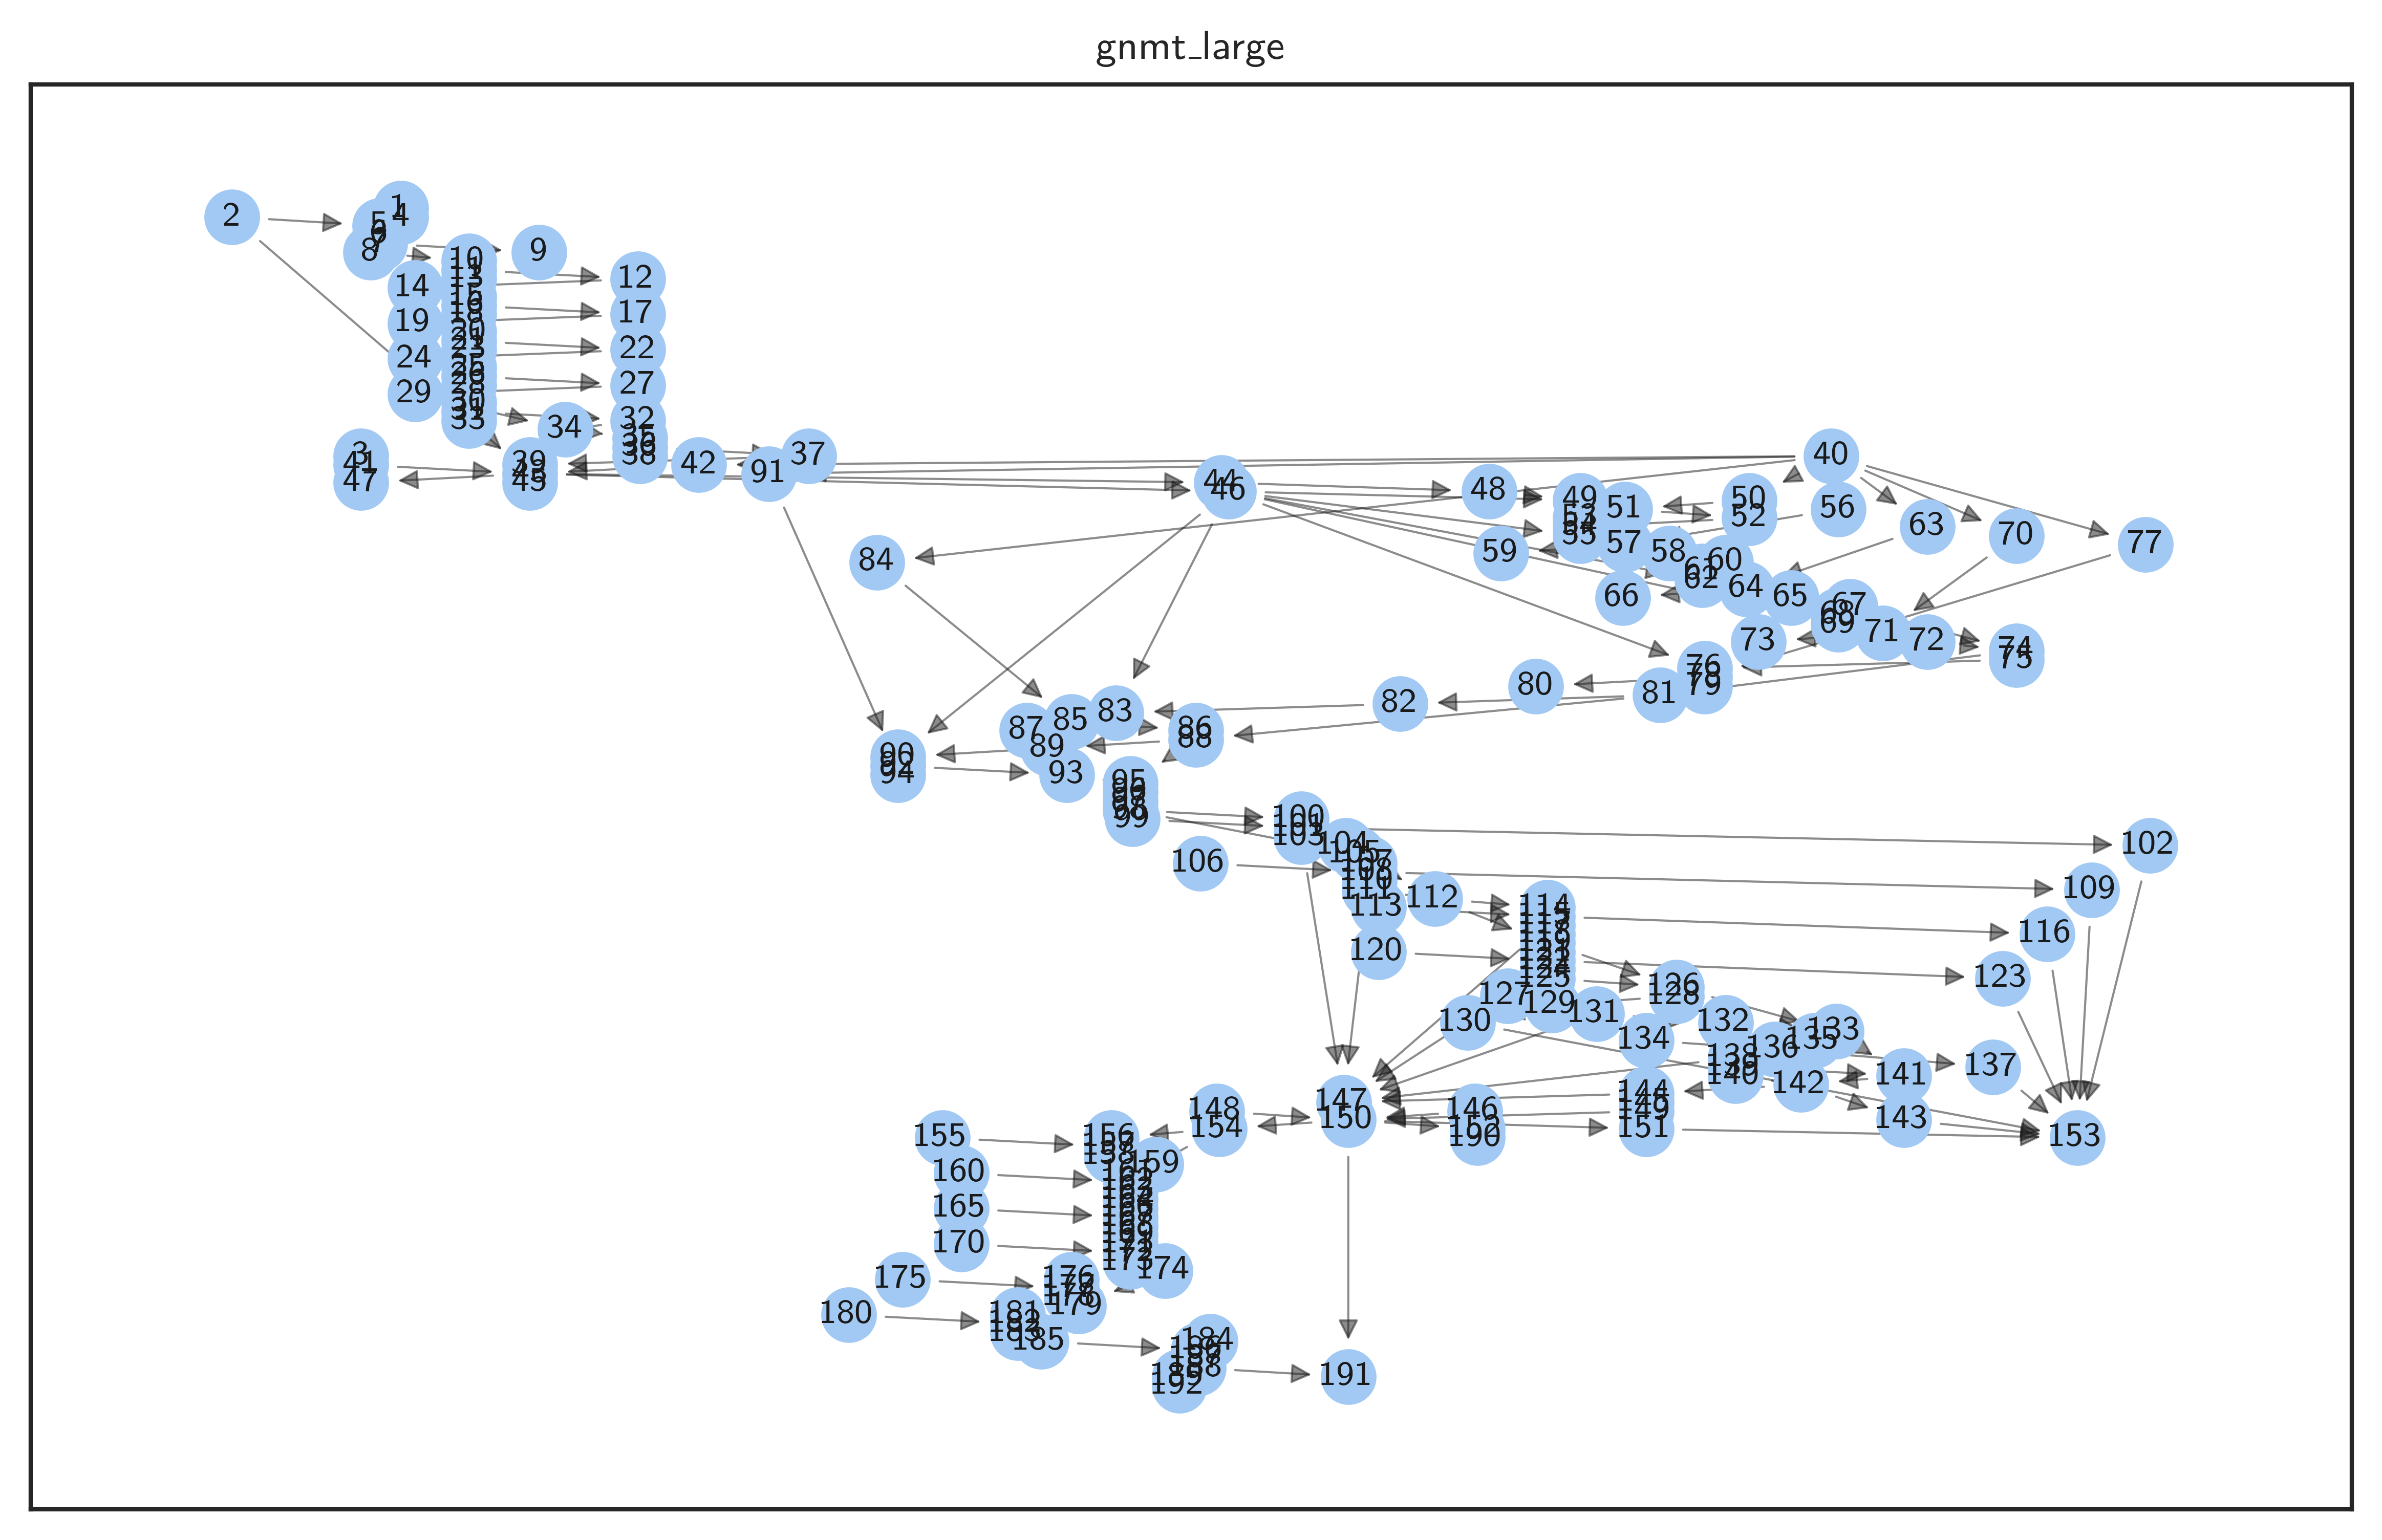

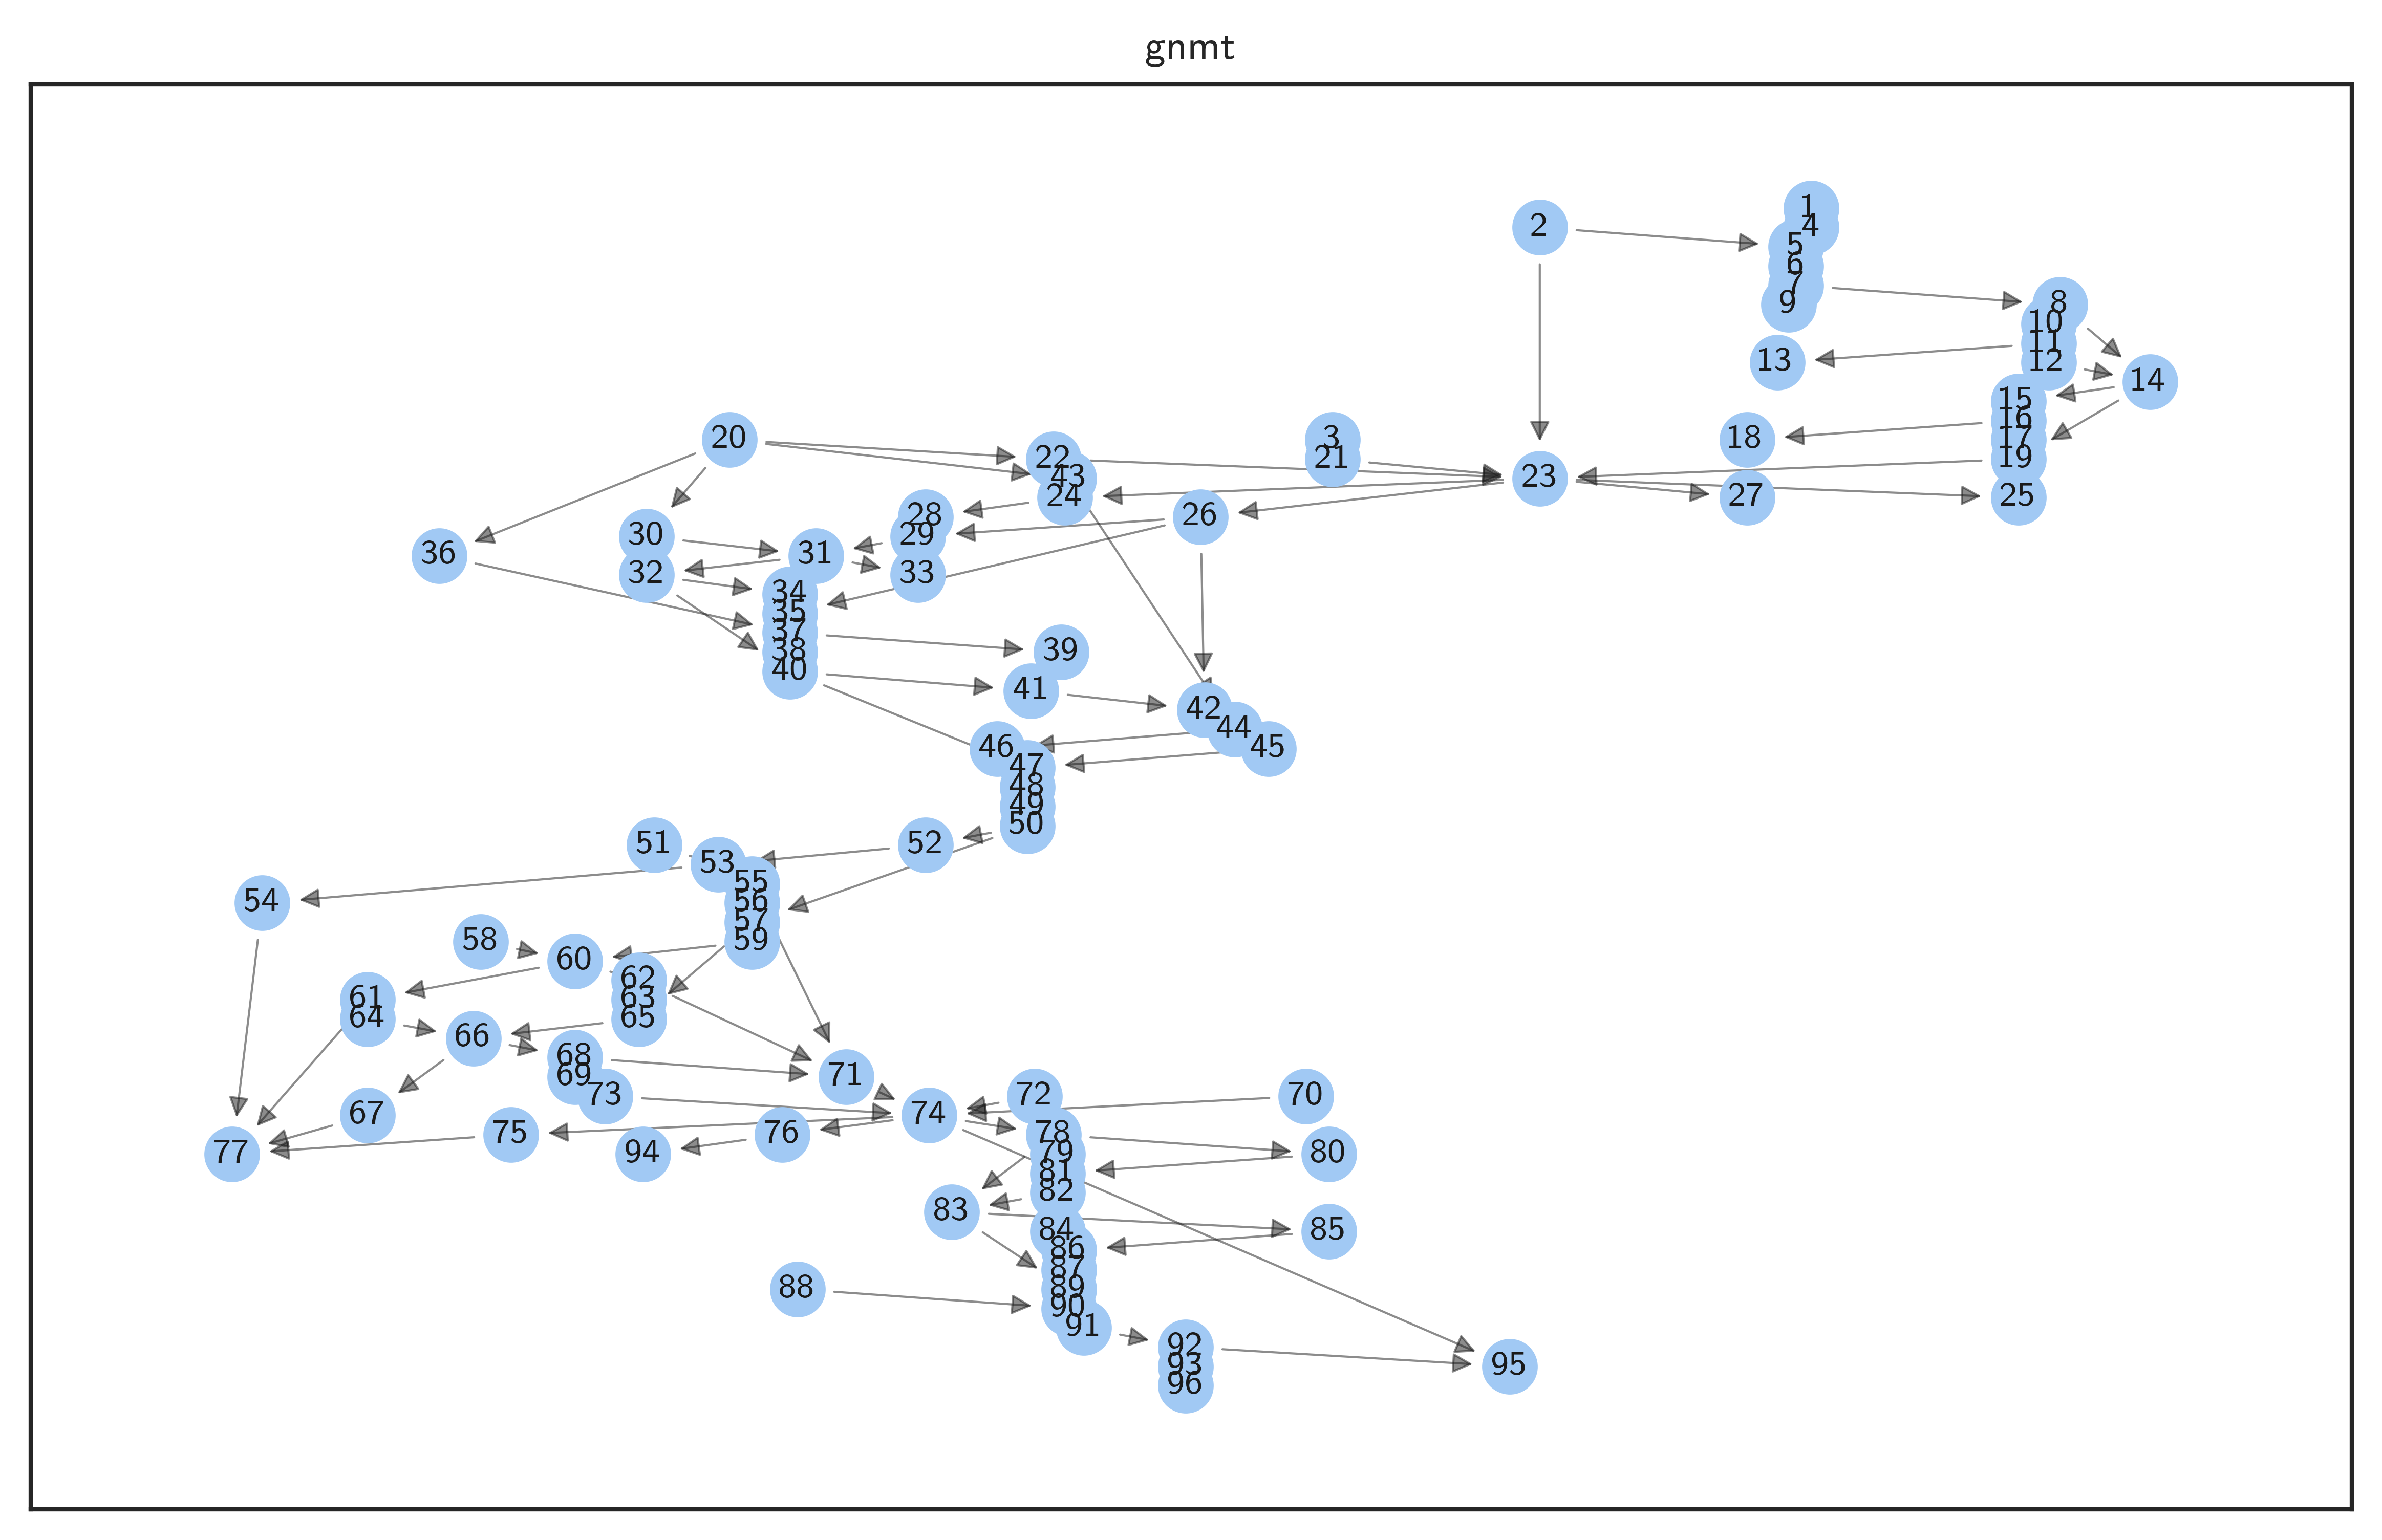

In [22]:
for job in jobs:
    job.render(title=job.details['model'])